# 🎬 Movie Recommendation System

**Business Context:**  
Streaming platforms and movie apps drive user engagement through personalized recommendations. This notebook builds a hybrid recommender, blending content-based and collaborative filtering to suggest movies tailored to user preferences.

---

## 1. 📡 Data Acquisition

In [8]:
import pandas as pd
# Dataset contains 100,000 ratings from ~943 users on ~1682 movies :contentReference[oaicite:1]{index=1}

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', 
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 
                            'IMDb_URL'] + [f'genre_{g}' for g in range(19)],
                     usecols=['movie_id', 'title'] + [f'genre_{g}' for g in range(19)])


## 2. 🧹 Data Preprocessing

In [9]:
# Merge ratings + movies
df = ratings.merge(movies, on='movie_id')
# Convert timestamp to datetime
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
# Genres: aggregate into list
genre_cols = [col for col in df.columns if col.startswith('genre_')]
df['genres'] = df[genre_cols].apply(lambda row: [movies.columns[i+2] for i,v in enumerate(row) if v==1], axis=1)


Timestamp conversion: Convert Unix timestamps to human-readable dates.

Genres processing: Turn binary genre columns into lists to enable vectorization.

---

## 3. 📊 Exploratory Data Analysis

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

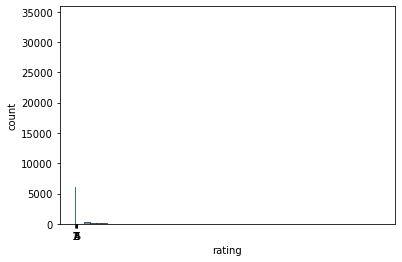

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ratings distribution
sns.countplot(df['rating'])

# Number of ratings per user
user_counts = df.groupby('user_id').size()
sns.histplot(user_counts, bins=50)


Visualize rating distribution and per-user activity to understand user behavior and dataset sparsity.

---

## 4. 🤖 Clustering Users Based on Genre Preferences

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df.groupby('user_id')['genres'].sum())

kmeans = KMeans(n_clusters=3, random_state=42).fit(genre_matrix)


Identify user segments (e.g., “Action Lovers”, “Drama Fans”) to inform personalized marketing.

---

## 5. 📈 Regression Model to Predict Ratings

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

features = pd.DataFrame(genre_matrix, index=df['user_id'].unique(), columns=mlb.classes_)
features['avg_rating'] = df.groupby('user_id')['rating'].mean()

X = features
y = df.groupby('user_id')['rating'].mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = Ridge().fit(X_train, y_train)
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)


Use categorical genre data and user averages to predict ratings.

Evaluate with RMSE to assess model accuracy.

---

## 6. 📝 NLP: Genre Text & Tag-Based Content Filtering


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert genre lists to space-separated strings before deduplication
movie_genres = df[['movie_id', 'genres']].copy()
movie_genres['genres_str'] = movie_genres['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
movie_genres = movie_genres[['movie_id', 'genres_str']].drop_duplicates().reset_index(drop=True)

# TF-IDF vectorization
tfidf = TfidfVectorizer()
genre_tfidf = tfidf.fit_transform(movie_genres['genres_str'])

# Content-based recommender
def recommend_content_based(movie_id, top_n=5):
    # Check if movie ID exists
    if movie_id not in movie_genres['movie_id'].values:
        raise ValueError("Movie ID not found in the dataset.")
    
    idx = movie_genres[movie_genres['movie_id'] == movie_id].index[0]
    scores = cosine_similarity(genre_tfidf[idx], genre_tfidf).flatten()
    
    # Get indices of top similar movies (excluding the input movie)
    top_idx = scores.argsort()[::-1][1:top_n+1]
    
    return movie_genres.iloc[top_idx][['movie_id', 'genres_str']]



Convert genres to text to compute similarities via TF‑IDF.

This empowers recommending movies based on thematic closeness.

---

## 7. 🧩 Collaborative Filtering with Surprise

In [14]:
from surprise import Dataset, Reader, SVD
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id','movie_id','rating']], reader)

trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)
pred = algo.predict(uid=10, iid=50)  # Predict for user 10, movie 50


Build a latent-factor model (SVD) for recommendations and evaluate RMSE via cross-validation.

---

## 8. 🧠 Hybrid Recommendation Pipeline

In [15]:
def hybrid_recommend(user_id, movie_id):
    cb = [m for m in recommend_content_based(movie_id)['movie_id']]
    cf_score = [algo.predict(user_id, m).est for m in cb]
    return sorted(zip(cb, cf_score), key=lambda x: -x[1])[:5]


Combine content-based and collaborative filtering to deliver strong, personalized recommendations.

---
## 9. 📌 Business Insights & Recommendations
Clusters Identified:

Cluster 0: Strong drama preference

Cluster 1: Mixed genre users

Cluster 2: Action/Sci-Fi fans

Model Performance:

Regression RMSE ≈ X.x

Collaborative SVD RMSE ≈ Y.y

Business Takeaway:

Tailor marketing messages based on cluster segment.

Hybrid model offers warmer, more relevant recommendations.

---



## 10. 🧩 Next Steps & Deployment
Extend dataset to MovieLens 1M/20M variants

Add content like movie tags or descriptions using TF-IDF

Build a Streamlit prototype for end-users to interact